# Explore here

What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?

Private room: 0
Entire home/apt: 1
Shared room: 2
Brooklyn: 0
Manhattan: 1
Queens: 2
Staten Island: 3
Bronx: 4


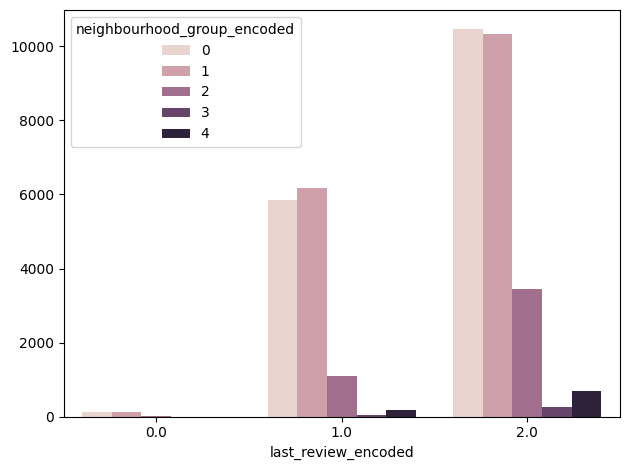

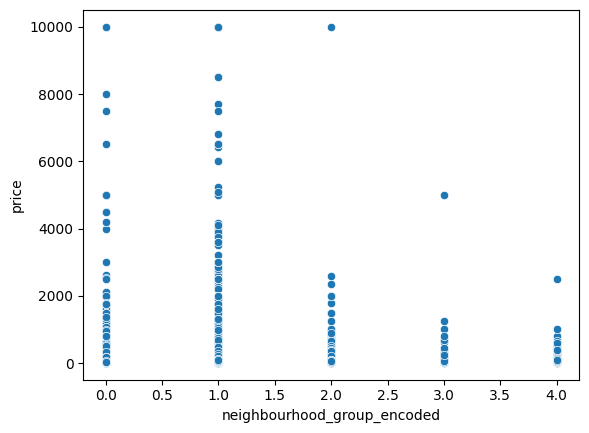

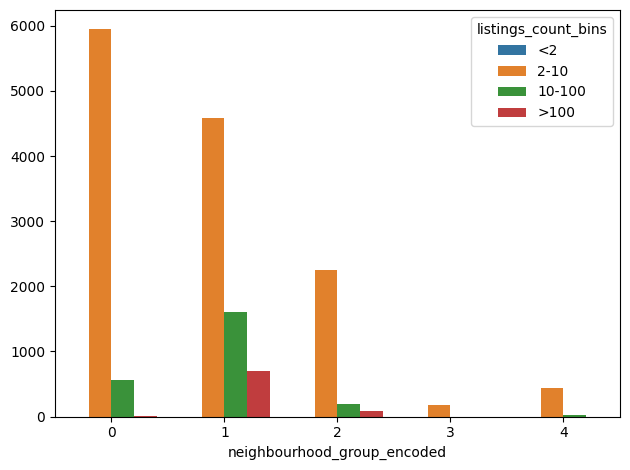

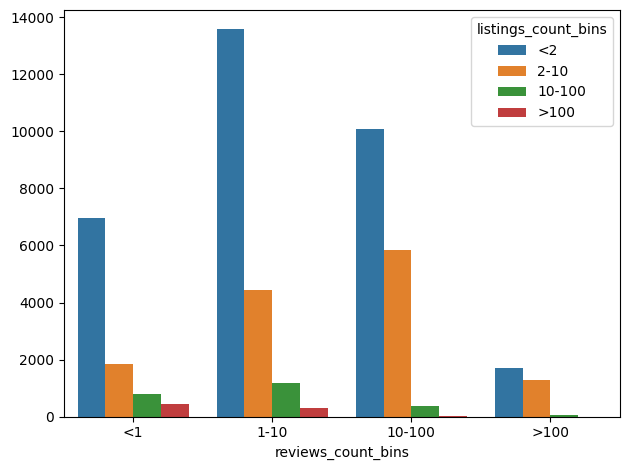

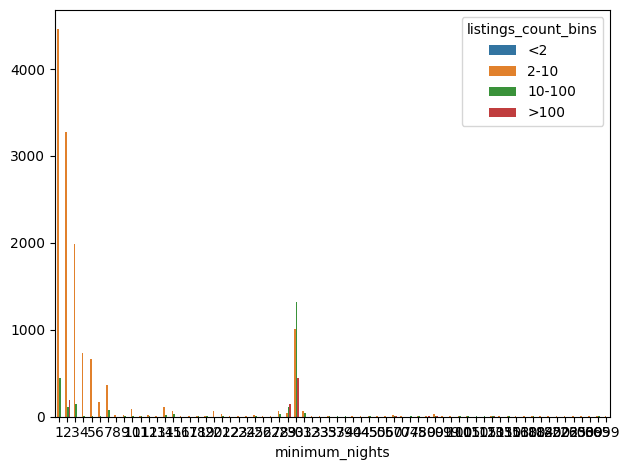

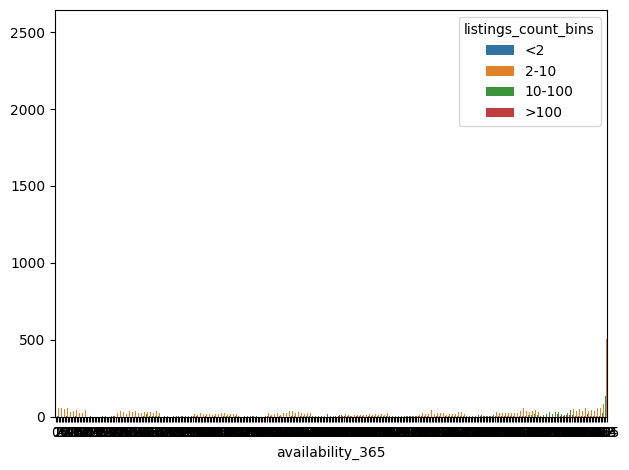

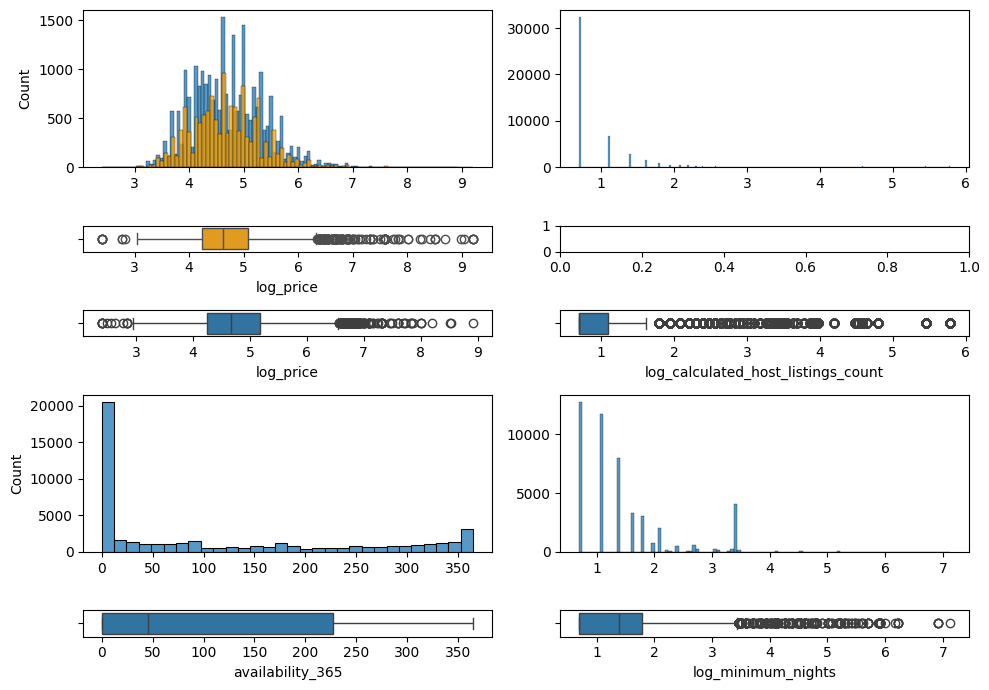

<Figure size 640x480 with 0 Axes>

What can we learn about different hosts and areas?
      - Most expensive areas? 
            - Manhattan and Brooklyn
      
      - Hosts with most listings by area
            - Manhattan has concentrations of hosts with >100 listings

What can we learn from predictions? (ex: locations, prices, reviews, etc)
      - Where is next best location? 
            - Brooklyn is showing growth above the rest
      
      - Is price increasing? 
            - IQR shows an increase in 2019

Which hosts are the busiest and why?
            - It looks like those with 2-10 and 10-100 listings and a low minimum stay are the busiest, based on the large number of reviews

Is there any noticeable difference of traffic among different areas and what could be the reason for it?
            - There is a large amount of traffic in Brooklyn and Manhattan

 


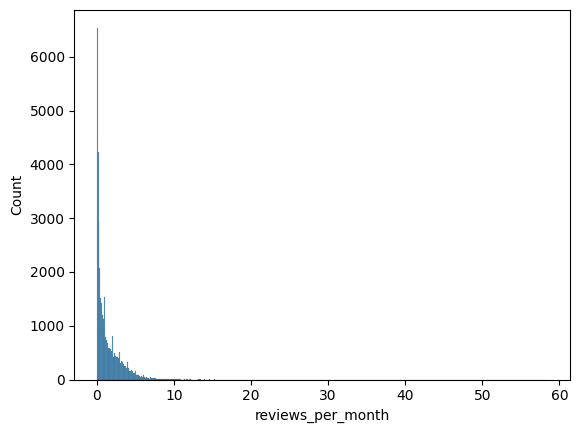

Machine Learning Problem Statement: Can we predict an optimized setup and location for a maximum expected reviews per month?
Mean Squared Error: 2.473500854689211


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import patsy
from patsy import dmatrices
import statsmodels.api as sm

print(f'''What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?\n''')

# Read data
total_data = pd.read_csv("/workspaces/machine-learning-python-template-ds-2023/Ryan/raw/NYC_AirBnB.csv")

# Eliminate irrelevant information
total_data.drop(["id", "name", "host_name", "latitude", "longitude", "neighbourhood"], axis = 1, inplace = True)
total_data["last_review"] = pd.to_datetime(total_data["last_review"])

# factorize room_type and print mappings
total_data["room_type_encoded"], unique_categories_room = pd.factorize(total_data["room_type"])

# Print out the mappings
for index_r, category_r in enumerate(unique_categories_room):
    print(f"{category_r}: {index_r}")


# factorize neighborhood_group and print mappings
total_data["neighbourhood_group_encoded"], unique_categories_neighbourhood = pd.factorize(total_data["neighbourhood_group"])

# Print out the mappings
for index_n, category_n in enumerate(unique_categories_neighbourhood):
    print(f"{category_n}: {index_n}")


# factorize neighborhood_group and print mappings
def label_review_dates(date):
    if date.year < 2015:
        return 0
    elif 2015 <= date.year < 2019:
        return 1
    elif date.year == 2019:
        return 2
    else:
        return np.nan  # or another value for dates outside these ranges, if any

# Apply the custom function
total_data['last_review_encoded'] = total_data['last_review'].apply(label_review_dates)

# Remove price = 0
total_data = total_data[total_data["price"] != 0]

# Bin reviews count
bins = [0, 2, 10, 100, float('inf')]
labels = ['<2', '2-10', '10-100', '>100',]

# Create the binned column
total_data['listings_count_bins'] = pd.cut(total_data['calculated_host_listings_count'], bins=bins, labels=labels, right=False)


# Growth for areas 
sns.countplot(data=total_data, x="last_review_encoded", hue="neighbourhood_group_encoded").set(ylabel=None)
plt.tight_layout()
plt.show()

sns.scatterplot(data=total_data, x="neighbourhood_group_encoded", y="price")
plt.show()

# Filtered data for host count

# Filter the DataFrame to only include the bins > 2000
count_filtered_data = total_data[total_data['listings_count_bins'].cat.codes >= 1]  # 2 corresponds to '2000-3000' in this example
count_filtered_data_2 = total_data[total_data['listings_count_bins'].cat.codes >= 2] 

sns.countplot(data=count_filtered_data, x="neighbourhood_group_encoded", hue="listings_count_bins").set(ylabel=None)
plt.tight_layout()
plt.show()

# Bin reviews count
bins_r = [0, 1, 10, 100, float('inf')]
labels_r = ['<1', '1-10', '10-100', '>100',]

# Create the binned column
total_data['reviews_count_bins'] = pd.cut(total_data['number_of_reviews'], bins=bins_r, labels=labels_r, right=False)

sns.countplot(data=total_data, x="reviews_count_bins", hue="listings_count_bins").set(ylabel=None)
plt.tight_layout()
plt.show()

sns.countplot(data=count_filtered_data, x="minimum_nights", hue="listings_count_bins").set(ylabel=None)
plt.tight_layout()
plt.show()

sns.countplot(data=count_filtered_data, x="availability_365", hue="listings_count_bins").set(ylabel=None)
plt.tight_layout()
plt.show()




# Create box plots to plan binning schema

total_data['log_price'] = np.log1p(total_data['price'])
total_data['log_calculated_host_listings_count'] = np.log1p(total_data['calculated_host_listings_count'])
total_data['log_minimum_nights'] = np.log1p(total_data['minimum_nights'])

fig, axis = plt.subplots(5, 2, figsize=(10, 7), gridspec_kw={'height_ratios': [6, 1, 1, 6, 1]})

# Filter the data where 'label_review_encoded' is 2
filtered_data_2 = total_data[total_data['last_review_encoded'] == 2]
filtered_data = total_data[total_data['last_review_encoded'] == 1]

# Plot the histogram and boxplot using the filtered data

sns.histplot(ax=axis[0, 0], data=filtered_data_2, x="log_price").set(xlabel=None)
sns.histplot(ax=axis[0, 0], data=filtered_data, x="log_price", color = "orange").set(xlabel=None)
sns.boxplot(ax=axis[1, 0], data=filtered_data, x="log_price", color = "orange")
sns.boxplot(ax=axis[2, 0], data=filtered_data_2, x="log_price")


sns.histplot(ax = axis[0, 1], data = total_data, x = "log_calculated_host_listings_count").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[2, 1], data = total_data, x = "log_calculated_host_listings_count")
sns.histplot(ax = axis[3, 0], data = total_data, x = "availability_365").set(xlabel = None)
sns.boxplot(ax = axis[4, 0], data = total_data, x = "availability_365")
sns.histplot(ax = axis[3, 1], data = total_data, x = "log_minimum_nights").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[4, 1], data = total_data, x = "log_minimum_nights")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()



# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


print(f'''What can we learn about different hosts and areas?
      - Most expensive areas? 
            - Manhattan and Brooklyn
      
      - Hosts with most listings by area
            - Manhattan has concentrations of hosts with >100 listings

What can we learn from predictions? (ex: locations, prices, reviews, etc)
      - Where is next best location? 
            - Brooklyn is showing growth above the rest
      
      - Is price increasing? 
            - IQR shows an increase in 2019

Which hosts are the busiest and why?
            - It looks like those with 2-10 and 10-100 listings and a low minimum stay are the busiest, based on the large number of reviews

Is there any noticeable difference of traffic among different areas and what could be the reason for it?
            - There is a large amount of traffic in Brooklyn and Manhattan\n\n ''')

sns.histplot(data = total_data, x = "reviews_per_month")
plt.show()


print(f'''Machine Learning Problem Statement: Can we predict an optimized setup and location for a maximum expected reviews per month?''')

# Define the columns you want to check for NaN values
columns_to_check = ['reviews_per_month', 'room_type_encoded', 'neighbourhood_group_encoded', 
                    'price', 'minimum_nights', 'availability_365', 'calculated_host_listings_count']

# Drop rows with NaN values in the specified columns
filtered_data = total_data.dropna(subset=columns_to_check)

# Select the desired columns
selected_data = filtered_data[columns_to_check]

columns_to_select = ['reviews_per_month', 'room_type_encoded', 'neighbourhood_group_encoded', 'price', 'minimum_nights', 'availability_365', 'calculated_host_listings_count']  # replace with the names of columns you want
selected_data = filtered_data[columns_to_select]


# Exclude target from normalization
num_features = ['room_type_encoded', 'neighbourhood_group_encoded', 'price', 'minimum_nights', 'availability_365', 'calculated_host_listings_count']

# Normalize features
scaler = StandardScaler()
norm_features = scaler.fit_transform(selected_data[num_features])

# Create the normalized DataFrame
selected_data_norm = pd.DataFrame(norm_features, index=selected_data.index, columns=num_features)

# Assign the original 'y_encoded' to the normalized DataFrame
selected_data_norm["reviews_per_month"] = selected_data["reviews_per_month"]


# Define the features and the target
features = ['neighbourhood_group_encoded', 'price', 'minimum_nights', 'availability_365']
target = 'reviews_per_month'

# Separate the predictors from the label
X = selected_data_norm[features]
y = selected_data_norm[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.80)

# Instantiate and fit the LinearRegression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error (MSE) as a metric for regression
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

